In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import StandardScaler

In [112]:
df_col_wage = pd.read_csv("RealMedWagesAdjCol.csv", index_col=0)
df_col_wage.index = pd.to_datetime(df_col_wage.index)
df_col_wage = df_col_wage.groupby(df_col_wage.index.year).mean()

Here is a graph of the the Real Median Wages Adjusted for Cost of Living in a selection of 24 different cities in the United States in 2011, 2015, and 2019. Clearly there are some large differences between different cities, although all have seem some real wage increase over the past decade. There are surely a variety of factors for these differences in real wages, and my goal is to find out how much of a factor housing availability in these differences.

(Use clustering to find important variables for housing availability, and find importance of that cluster?)

Housing availability is somewhat of an ambiguous variable, so I'll be measuring it in a couple different ways. The first and most straight forward is the number of rental vacancies in each city. Theoretically, if the vacancy rate is high, then the housing supply is exceeding the housing demand, so there is a high level of housing availability. 

Another potentially important variable is the ratio of Single Unit Development permits to All Development permits. Essentially this measures what percentage of a city's buulding permits are going to single unit houses/apartments. Cities with higher ratios will likely have a lower housing supply and less housing availability. 

My hypothesis is that more housing availability in a given metro area causes the net income of that area to increase. The first reason I think this is because when people live in denser areas, the cost of living should decrease. This is because of supply and demand, as the number of housing units (apartments or houses) increase the price of rent should decrease acordingly. Another reason for this is that there is less need for transportation, both for the individual to get to work or to stores, and for companies who can ship more of their products into one central location rather than a sprawling set of different locations.  The second reason I think this is because denser areas lead to more interactions between people, which ultimately leads to more innovation and productivity, which should increase wages. 

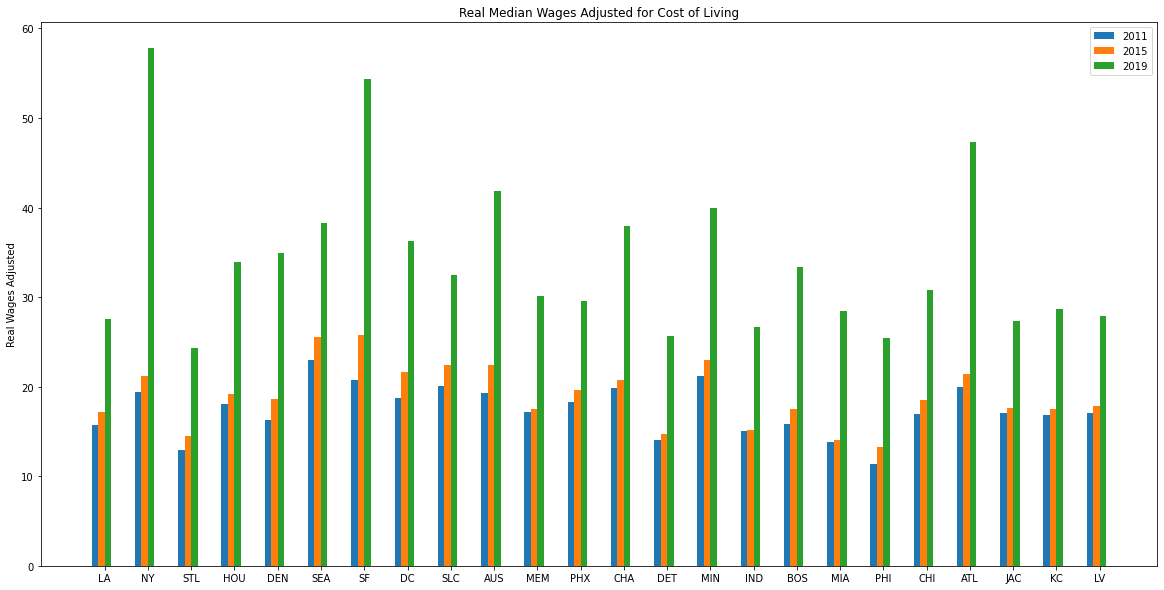

In [113]:
labels = df_col_wage.columns
means_11 = df_col_wage.loc[2011].values
means_15 = df_col_wage.loc[2015].values
means_19 = df_col_wage.loc[2019].values

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(20,10))

rect1 = ax.bar(x - width/2, means_11, width, label='2011')
rect2 = ax.bar(x, means_15, width, label='2015')
rect3 = ax.bar(x + width/4, means_19, width/2, label='2019')

ax.set_ylabel('Real Wages Adjusted')
ax.set_title('Real Median Wages Adjusted for Cost of Living')
ax.legend()
plt.xticks(x, labels)

#ax.bar_label(rect1, padding=3)
#ax.bar_label(rect2, padding=3)
plt.show()

In [114]:
df_permits = pd.read_csv('BuildingPermits.csv', index_col=0)
df_permits.index = pd.to_datetime(df_permits.index)
df_permits = df_permits.groupby(df_permits.index.year).mean()
# Here I take the average number of permits over each year

# Here I find the percent of permits that are for single unit development
for i in range(int(len(df_permits.columns)*1/2 + 1)):
    df_permits[df_permits.columns[2*i].replace('Any', 'Ratio')] = 100*df_permits[df_permits.columns[2*i + 
                                                                        1]]/df_permits[df_permits.columns[2*i]]
    
df_ratios = df_permits[df_permits.columns[48:]]

In [115]:
# Here I merge the permit ratios and real median wages so I can get them in a single dataframe for easier plotting
df_ratios = df_ratios.transpose()
df_rt_yrs = df_ratios[list(np.arange(2009, 2020))].reset_index()

cities = []
for index, item in df_rt_yrs.iterrows():
    cities.append(item['index'].replace("_Ratio", ''))
    
df_rt_yrs['City'] = cities
df_rt_yrs.drop('index', axis=1, inplace=True)

dft = df_col_wage.transpose()
df_cw_yrs = dft[list(np.arange(2009, 2020))]

df_wage_and_permits = df_rt_yrs.merge(df_cw_yrs, left_on="City", right_index=True, 
                                      suffixes=("_Ratio", "_COL_Wage"))

In [116]:
# Here I create a new dataframe to get both years and cities in the rows so I can plot permits vs. 
# real median wages. I do this by looping through each row and concatenating them vertically

ratios = []

for i in df_wage_and_permits.columns[:11]:
    for index, item in df_wage_and_permits.iterrows():
        ratios.append(item[i])

wages = []
for i in df_wage_and_permits.columns[12:]:
    for index, item in df_wage_and_permits.iterrows():
        wages.append(item[i])

year = []
counter = 0
current = 2009
for i in range(len(wages)):
    year.append(current)
    counter += 1
    
    if counter%24 == 0:
        current +=1


city = []
for i in range(11):
    city.extend(df_wage_and_permits['City'].tolist())

wage_vs_permit = pd.DataFrame({"City":city, "Year":year, "Permit_Ratio":ratios, "COL_Wage":wages})

# For some reason the ratio for LA isn't computing correcty so I'm excluding it for now
wage_vs_permit = wage_vs_permit[wage_vs_permit['City']!='LA']

The variable I will be using to approximate net income is Real Median Wages Adjusted for Cost of Living. As a preliminary test, I plotted this vs the permit ratio that I mentioned above. While this plot and linear regression doesn't prove anything yet, it does show that there is a negative correlation between the percentage of permits given out for single unit housing and the real adjusted wage. Although the R squared is pretty small, there is a significant coefficient associated with Permit_Ratio, even after taking out the outliers of New York and San Francisco. This shows that the relationship that I suspect may be there, but there are quite a few other confounding variables to consider.

In [117]:
X = wage_vs_permit[['Permit_Ratio']]
X = sm.add_constant(X)
y = wage_vs_permit['COL_Wage']

result = sm.OLS(y, X).fit()
print(result.summary())

fig = px.scatter(wage_vs_permit, x='Permit_Ratio', y='COL_Wage', hover_name='City', color='Year', trendline='ols',
                title='Median Real Adjusted Wages vs Permit Ratio')
#fig.add_scatter(x=x, y=y_pred, mode='lines', name="Linear Regression Fit")
fig.show()

                            OLS Regression Results                            
Dep. Variable:               COL_Wage   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     26.34
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           5.73e-07
Time:                        21:59:39   Log-Likelihood:                -901.98
No. Observations:                 253   AIC:                             1808.
Df Residuals:                     251   BIC:                             1815.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           34.2358      2.004     17.085   

In [118]:
wvp_no_outliers = wage_vs_permit[(wage_vs_permit['City']!="NY") & (wage_vs_permit['City']!="SF")]
X = wvp_no_outliers[['Permit_Ratio']]
X = sm.add_constant(X)
y = wvp_no_outliers['COL_Wage']

result = sm.OLS(y, X).fit()
print(result.summary())

fig = px.scatter(wvp_no_outliers, x='Permit_Ratio', y='COL_Wage', hover_name='City', color='Year', trendline='ols',
                title='Median Real Adjusted Wages vs Permit Ratio (Outliers Excluded)')

fig.show()

                            OLS Regression Results                            
Dep. Variable:               COL_Wage   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.635
Date:                Sun, 13 Mar 2022   Prob (F-statistic):             0.0184
Time:                        21:59:39   Log-Likelihood:                -791.88
No. Observations:                 231   AIC:                             1588.
Df Residuals:                     229   BIC:                             1595.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           28.4625      2.192     12.985   

In [141]:
# Here I'm importing a more comprehensive dataset, the 2019 ACS profile, but it only covers one year
df1 = pd.read_csv('ACSAggData2.csv')
df1 = df1.transpose().reset_index()
df1.columns = df1.iloc[0]
df1.drop(df1.index[0], inplace=True)
df1.rename(columns={"Unnamed: 0": "Metro"}, inplace=True)

# Clean the whitespace that's around the column names
new_cols = []
for i in df1.columns:
    new_cols.append(i.strip())
    
df1.columns = new_cols

In [142]:
# Recast the datatypes so they're compatible for OLS regression
df1 = df1.astype({'Gross rent 30% or more of HH income':"float", 'For rent':'float', 
                  'Vacant housing units':'float'})

In [143]:
# Split the raw numbers and percentages up and drop the null percents
df_raw = df1[df1['Metro'].str.contains("Raw")]
df_pct = df1[df1['Metro'].str.contains("Pct")]
df_pct.dropna(axis=1, inplace=True)

<ipython-input-143-33e25f70df5b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



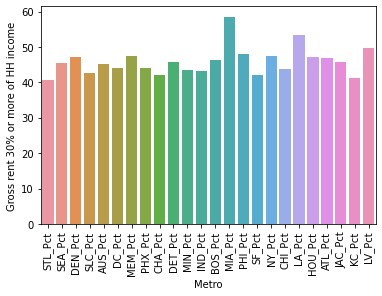

In [144]:
# I thought this might be a useful graph
sns.barplot(x = "Metro", y='Gross rent 30% or more of HH income', data=df_pct)
plt.xticks(rotation=90)
plt.show()

In [145]:
# Here I add the 2019 real median wages to the more comprehnsive ACS data
metros = []
for index, item in df_pct.iterrows():
    metros.append(item['Metro'].replace('_Pct', ''))
    
df_pct['Metro'] = metros
COL_Wage_19 = wage_vs_permit[wage_vs_permit['Year']==2019][['COL_Wage', 'City']]
df_pct = df_pct.merge(COL_Wage_19, left_on="Metro", right_on='City')

<ipython-input-145-8c7e7fa4377a>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



I'm surprised to see a negative correlation here, this could be a case of reverse causality where the low real wages make housing less affordable which leads to mroe vacancies

In [146]:
X = df_pct[['Vacant housing units']]
X = sm.add_constant(X)
y = df_pct['COL_Wage']

result = sm.OLS(y, X).fit()
print(result.summary())

px.scatter(df_pct, x="Vacant housing units",y="COL_Wage", hover_name='Metro',
          trendline='ols')

                            OLS Regression Results                            
Dep. Variable:               COL_Wage   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     4.982
Date:                Sun, 13 Mar 2022   Prob (F-statistic):             0.0366
Time:                        22:05:55   Log-Likelihood:                -80.123
No. Observations:                  23   AIC:                             164.2
Df Residuals:                      21   BIC:                             166.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   48.1789 

In [126]:
# I begand trying to evaluate the housing price index data, but it's incomplete and doesn't cover all of the 
# cities that I'm looking at.
df_cs = pd.read_csv("CaseShillerIndex.csv", index_col=0)
df_cs.index = pd.to_datetime(df_cs.index)
df_cs = df_cs.groupby(df_cs.index.year).mean()


In [127]:
df_cs.transpose()

DATE,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
LA,63.216349,76.361918,94.770785,99.363525,94.073038,89.691358,81.088848,76.745994,74.852474,74.075112,...,168.858241,201.218611,221.954938,235.169607,248.792786,263.442501,280.417875,285.394389,302.097174,352.515504
SEA,65.511398,65.974565,67.139369,68.530383,71.232200,72.245546,74.108393,79.765094,88.658224,96.529890,...,180.333747,199.798929,225.271596,248.695097,252.297394,274.030745,333.800564,NaN,NaN,NaN
DEN,50.245879,48.439425,47.660405,48.575705,50.035121,53.925107,58.783824,65.485730,69.738637,73.395646,...,129.745630,142.181476,153.277856,168.945255,184.545676,198.778749,213.896643,221.764705,233.407802,274.830002
AUS,49.227081,57.281840,68.902209,73.763608,70.656341,69.419212,67.406193,67.516265,67.309511,67.503345,...,137.139777,169.008238,192.360003,211.917032,226.747039,242.005868,264.329343,266.267905,278.815151,327.008647
DC,69.020037,80.100341,90.334118,92.388698,88.696270,88.632695,88.863197,89.759179,88.955226,88.731306,...,185.630816,198.441028,207.713393,209.994514,213.601744,220.175624,226.180752,232.663330,245.215532,276.109110
DET,58.891101,60.746732,62.809682,66.166790,71.188432,76.640395,82.153872,88.236711,95.643315,103.393319,...,107.367384,114.918950,122.438374,126.933374,133.639513,152.625972,NaN,NaN,NaN,NaN
PHX,67.292347,66.261278,65.339862,66.224581,68.297988,72.756086,76.906975,81.079932,84.543479,89.454873,...,146.408986,152.791896,160.911763,169.925848,181.982628,193.178576,212.706977,271.023247,NaN,NaN
MIN,63.624959,64.335290,65.130541,67.188433,69.612527,72.840703,75.337541,77.774771,81.131798,85.692480,...,140.140643,144.876309,151.935698,160.779476,170.386737,177.139410,188.403325,211.141377,NaN,NaN
BOS,72.506800,74.715743,74.127577,69.896332,64.226234,64.014465,65.420586,68.046544,69.563551,72.331169,...,152.312762,163.301539,173.666816,180.684550,189.124826,201.759239,213.381727,221.451764,235.381290,272.322485
MIA,69.954695,73.933270,77.804542,79.605537,78.851030,78.937606,81.378012,85.477245,87.056818,87.683723,...,145.997975,166.036605,186.002081,200.739589,213.910493,224.851660,235.684546,243.912167,256.151424,306.959724
